In [1]:
# This is the template for the submission. You can develop your algorithm in a regular Python script and copy the code here for submission.

# TEAM NAME ON KAGGLE
# "EXAMPLE_GROUP"

# GROUP NUMBER
# "group_XX"

# TEAM MEMBERS (E-MAIL, LEGI, KAGGLE USERNAME):
# "examplestudent1@ethz.ch", "12-345-678", "eXampl3stdNtone" 
# "examplestudent2@ethz.ch", "12-345-679", "xXexamplestudent2Xx"
# "examplestudent3@ethz.ch", "12-345-670", "mhealth_student_98"

In [64]:
from os import listdir
from os.path import isfile, join
import re

import pandas as pd
import numpy as np

# You may change the mhealth_activity module but your algorithm must support the original version
from mhealth_activity import Recording
import matplotlib.pyplot as plt

import torch
from torch import nn

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

# For interactive graphs
# %matplotlib widget

In [132]:

# Get the path for all test traces
'''
dir_traces_test = 'data/test'
filenames_test = [join(dir_traces_test, f) for f in listdir(dir_traces_test) if isfile(join(dir_traces_test, f))]
filenames_test.sort()
recordings_test = []
for fn in filenames_test:
    rec = Recording(fn)
    match = re.search(r'(\d{3})\.pkl$', fn)
    if match:
        id = int(match.group(1))
        rec.id = id
    else:
        raise ValueError(f'Filename {fn} does not match expected format')
    recordings_test.append(rec)
'''
    
    
dir_traces_train = 'data/train'
filenames_train = [join(dir_traces_train, f) for f in listdir(dir_traces_train) if isfile(join(dir_traces_train, f))]
filenames_train.sort()

alts_train = []
path_idxs = []
activities = []
mxs = []
mys = []
mzs = []
axs = []
ays = []
azs = []
for fn in filenames_train:
    rec = Recording(fn)
    alts_train.append(rec.data['altitude'].values)
    path_idxs.append(rec.labels['path_idx'])
    #activities.append(rec.labels['activities'])
    mxs.append(rec.data['mx'].values)
    mys.append(rec.data['my'].values)
    mzs.append(rec.data['mz'].values)
    axs.append(rec.data['ax'].values)
    ays.append(rec.data['ay'].values)
    azs.append(rec.data['az'].values)

In [133]:
dir_traces_test = 'data/test'
filenames_test = [join(dir_traces_test, f) for f in listdir(dir_traces_test) if isfile(join(dir_traces_test, f))]
filenames_test.sort()

alts_test = []

for fn in filenames_test:
    rec = Recording(fn)
    alts_test.append(rec.data['altitude'].values)
    

In [110]:
from scipy.signal import argrelextrema, find_peaks
from torch.utils.data import TensorDataset, DataLoader

def centered_moving_average(data, window_size):
    ret = np.cumsum(data, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    return ret[window_size - 1:] / window_size
def plot_array(arr):
    plt.figure(figsize=(25, 3))
    plt.plot(arr)
    plt.show()

def windowed_peak_detection(data, window_size):
    # Initialize an empty list to store the peaks
    peaks = []

    # Divide the data into windows
    for i in range(0, len(data), window_size):
        window = data[i:i + window_size]

        # Compute the relative maxima of the window
        window_peaks = argrelextrema(window, np.greater)

        # Add the indices of the peaks to the list
        peaks.extend(window_peaks[0] + i)

    return np.array(peaks)

def get_steps_from_peaks(data, peaks, threshold=1.25):
    steps=0
    for peak in peaks:
        if data[peak]>threshold:
            steps+=1
    return steps

def get_steps(data, window_size=80, threshold=1.25):
    peaks, _ = find_peaks(data, height=1.25, distance=80)
    steps = get_steps_from_peaks(data, peaks, threshold)
    return steps

with open('indices.txt', 'r') as f:
    indices = [line.rstrip() for line in f]
    

def pad_arrays(arr_list):
    max_len = max(len(arr) for arr in arr_list)
    return [np.pad(arr, (0, max_len - len(arr)), 'constant') for arr in arr_list]

def pad_arrays_len(arr_list, pad_length=10032):
    #10032
    return [np.pad(arr, (0, pad_length - len(arr)), 'constant') if len(arr) < pad_length else arr[:pad_length] for arr in arr_list]

def create_one_hot_vector(num):
    return [1 if i == num else 0 for i in range(5)]

def create_dataloaders(X, y, batch_size=16, test_size=0.2):
    # Convert X and y into PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=test_size)

    # Create TensorDatasets for the training and testing sets
    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)

    # Create DataLoaders for the training and testing sets
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

def train_model(dataloader, model, epochs=5):
    size = len(dataloader.dataset)
    
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    for i in range(epochs):
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            #print('pred:', pred, 'y:', y)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss, current = loss.item(), batch * len(X)
        #print(f"loss: {loss:>7f} ")
        
def make_predictions(model, dataloader):
    model.eval()
    predictions = []
    y_true = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            output = model(X)
            _, predicted = torch.max(output.data, 1)
            predictions.extend(predicted.cpu().numpy())
            y = torch.max(y, 1)[1]
            y_true.extend(y.cpu().numpy())
    return predictions, y_true

def plot_arrays(arrays):
    for array in arrays:
        plt.plot(array)
    plt.legend()
    plt.show()
    
def clean_data(data:np.array):
    min = np.min(data[:500])
    max = np.max(data[:500])
    diff = max-min
    if diff > 30:
        n_data = data[500:]
    else:
        n_data = data
        
    n_data = centered_moving_average(n_data, 100)
    return n_data

def downsample_time_series(time_series):
    # Calculate the downsampling factor
    downsample_factor = int(200 / 12.5)

    # Reshape the time series into chunks of size downsample_factor
    reshaped_time_series = time_series[:len(time_series) // downsample_factor * downsample_factor].reshape(-1, downsample_factor)

    # Average each chunk to get the downsampled time series
    downsampled_time_series = reshaped_time_series.mean(axis=1)

    return downsampled_time_series

In [94]:
rec = Recording(filenames_train[0])
rec.data['mx'].samplerate

12.5189357023906

In [134]:
data_alt_train = []
for d in alts_train:
    data_alt_train.append(clean_data(d))
data_alt_train = pad_arrays_len(data_alt_train)

data_alt_test = []
for d in alts_test:
    data_alt_test.append(clean_data(d))
data_alt_test = pad_arrays_len(data_alt_test)
'''for d in mxs:
    data_mx.append(centered_moving_average(d, 30))
data_mx = pad_arrays(data_mx)
for d in mys:
    data_my.append(centered_moving_average(d, 30))
data_my = pad_arrays(data_my)
for d in mzs:
    data_mz.append(centered_moving_average(d, 30))
data_mz = pad_arrays(data_mz)
for d in axs:
    d = downsample_time_series(d)
    data_ax.append(centered_moving_average(d, 30))
data_ax = pad_arrays(data_ax)
for d in ays:
    d = downsample_time_series(d)
    data_ay.append(centered_moving_average(d, 30))
data_ay = pad_arrays(data_ay)
for d in azs:
    d = downsample_time_series(d)
    data_az.append(centered_moving_average(d, 30))
data_az = pad_arrays(data_az)
data_tot = np.concatenate((data_alt_train, data_mx, data_my, data_mz, data_ax, data_ay, data_az), axis=1)
print(data_tot.shape)
plot_arrays([data_ax[0], data_ay[0], data_az[0]])'''

'for d in mxs:\n    data_mx.append(centered_moving_average(d, 30))\ndata_mx = pad_arrays(data_mx)\nfor d in mys:\n    data_my.append(centered_moving_average(d, 30))\ndata_my = pad_arrays(data_my)\nfor d in mzs:\n    data_mz.append(centered_moving_average(d, 30))\ndata_mz = pad_arrays(data_mz)\nfor d in axs:\n    d = downsample_time_series(d)\n    data_ax.append(centered_moving_average(d, 30))\ndata_ax = pad_arrays(data_ax)\nfor d in ays:\n    d = downsample_time_series(d)\n    data_ay.append(centered_moving_average(d, 30))\ndata_ay = pad_arrays(data_ay)\nfor d in azs:\n    d = downsample_time_series(d)\n    data_az.append(centered_moving_average(d, 30))\ndata_az = pad_arrays(data_az)\ndata_tot = np.concatenate((data_alt_train, data_mx, data_my, data_mz, data_ax, data_ay, data_az), axis=1)\nprint(data_tot.shape)\nplot_arrays([data_ax[0], data_ay[0], data_az[0]])'

In [135]:
X_train_data = np.array(pad_arrays(data_alt_train))
y_train_data = np.array(path_idxs)
X_test_data = np.array(pad_arrays(data_alt_test))

In [151]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2)

for dep in [5]:
    model = XGBClassifier(objective='multi:softmax', num_class=5, subsample=1, reg_lambda=1, n_estimators=100, max_depth=6)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, y_pred, adjusted=True)
    #print(y_pred)
    print(f"B Accuracy: {accuracy:.4f}, n_est: {dep}")

B Accuracy: 0.6022, n_est: 5


balanced accuracy with altitude(preprocessed): 66.93% (no hyperparameter tuning)

balanced accuracy with altitute and magnetometer: 59.37% (no hyperparameter tuning)

balanced accuracy with altitude, magnetometer and acceleration: 53.37%(no hyperparameter tuning)



In [137]:
confusion_matrix(y_test, y_pred)

array([[ 7,  6,  1,  0,  1],
       [ 4,  7,  2,  1,  0],
       [ 1,  0, 14,  0,  0],
       [ 1,  0,  0, 17,  1],
       [ 0,  0,  0,  2, 15]], dtype=int64)

In [138]:
y_solution = model.predict(X_test_data)
np.count_nonzero(y_solution == 0), np.count_nonzero(y_solution == 1), np.count_nonzero(y_solution == 2), np.count_nonzero(y_solution == 3), np.count_nonzero(y_solution == 4)

(68, 43, 48, 53, 68)

In [60]:
class CNN_clf(nn.Module):
    def __init__(self):
        super(CNN_clf, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=15, padding=7, stride=3)
        self.pool1 = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=7, padding=3)
        self.pool2 = nn.MaxPool1d(3)
        self.fc0 = nn.Linear(11872, 4096)
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, 5)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool1(nn.functional.relu(x))
        x = self.conv2(x)
        x = self.pool2(nn.functional.relu(x))
        #print(x.shape)
        x = x.view(-1, 11872)
        x = nn.functional.relu(self.fc0(x))
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

100%|██████████| 50/50 [09:03<00:00, 10.87s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


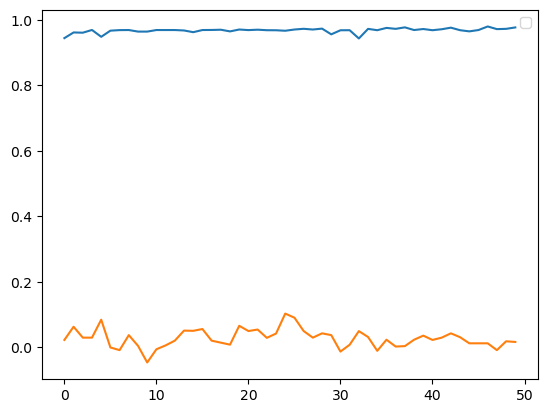

In [62]:
import tqdm
y_new = np.array([create_one_hot_vector(yi) for yi in y])
train_loader, test_loader = create_dataloaders(X, y_new)
model = CNN_clf()
#for i in range(50):
train_acc = []
test_acc = []
for i in tqdm.tqdm(range(50)):
    train_model(train_loader, model, 10)
    y_pred, y_true = make_predictions(model, test_loader)
    test_acc.append(balanced_accuracy_score(y_true, y_pred, adjusted=True))
    y_pred, y_true = make_predictions(model, train_loader)
    train_acc.append(balanced_accuracy_score(y_true, y_pred, adjusted=True))

plot_arrays([train_acc, test_acc])

In [66]:
y_pred, y_true = make_predictions(model, test_loader)
#y_true = test_loader.dataset.tensors[1].max(1)[1]
confusion_matrix(y_true, y_pred)

array([[ 2, 10,  4,  3,  1],
       [ 2,  3,  2,  2,  3],
       [ 4,  1,  7,  4,  1],
       [ 3,  2,  2,  3,  2],
       [ 5,  5,  3,  5,  1]], dtype=int64)

In [7]:
# Loop through all filenames to process recordings
filenames_test = []
submission = []
for filename in filenames_test:
    recording = Recording(filename)
    
    # Assumes filename format ends with a three-digit ID before ".pkl"
    match = re.search(r'(\d{3})\.pkl$', filename)
    if match:
        id = int(match.group(1))
        recording.id = id
    else:
        raise ValueError(f'Filename {filename} does not match expected format')

    # Placeholder for the algorithm to process the recording
    # Implement the logic to infer watch location, path index, step count,
    # and activities (standing, walking, running, cycling) here.
    # Ensure your algorithm is tolerant to missing data and does not crash
    # when optional smartphone data traces are missing.

    path_idx = 0  # Integer, path in {0, 1, 2, 3, 4}
    watch_loc = 0  # Integer, 0: left wrist, 1: belt, 2: right ankle
    standing = False  # Boolean, True if participant was standing still throughout the recording
    walking = False  # Boolean, True if participant was walking throughout the recording
    running = False  # Boolean, True if participant was running throughout the recording
    cycling = False  # Boolean, True if participant was cycling throughout the recording
    step_count = 0  # Integer, number of steps, must be provided for each recording

    predictions = {
        'Id': id, 
        'watch_loc': watch_loc, 
        'path_idx': path_idx,
        'standing': standing,
        'walking': walking,
        'running': running,
        'cycling': cycling,
        'step_count': step_count
        }

    submission.append(predictions)

In [139]:
# Write the predicted values into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using a text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns of the .csv file ("Id", "watch_loc", "path_idx", "standing", "walking", "running", "cycling", "step_count")
submission = []
for i in range(len(y_solution)):
    predictions = {
        'Id': i, 
        'watch_loc': 0, 
        'path_idx': y_solution[i],
        'standing': False,
        'walking': False,
        'running': False,
        'cycling': False,
        'step_count': 0
    }
    submission.append(predictions)

submission_df = pd.DataFrame(submission, columns=['Id', 'watch_loc', 'path_idx', 'standing', 'walking', 'running', 'cycling', 'step_count'])
submission_df.to_csv('submission.csv', index=False)